In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import numpy as np
warnings.simplefilter("ignore")

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, fbeta_score, accuracy_score,\
                            balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split

In [2]:
APPLICATIONS_FILENAME = os.path.join("Data", "Applications.csv")
CONTRACTS_FILENAME = os.path.join("Data", "Contracts.csv")
NBCH_INFO_FILENAME = os.path.join("Data", "nbch_info.csv")
NBCH_INFO_FILENAME_NEW = os.path.join("Data", "nbch_info_new.csv")
NBCH_INQUIRIES_FILENAME = os.path.join("Data", "nbch_inquiries.csv")
NBCH_LOANS_FILENAME = os.path.join("Data", "nbch_loans.csv")
NBCH_LOANS_NEW_FILENAME = os.path.join("Data", "nbch_loans_new.csv")
NBCH_LOAN_PAYMENTS_FILENAME = os.path.join("Data", "nbch_loan_payments.csv")
NBCH_OBJECTS_FILENAME = os.path.join("Data", "nbch_objects.csv")

In [3]:
# Read data
applications_df = pd.read_csv(APPLICATIONS_FILENAME, index_col=0)
contracts_df = pd.read_csv(CONTRACTS_FILENAME, index_col=0)
nbch_loans_df = pd.read_csv(NBCH_LOANS_NEW_FILENAME, index_col=0)

nbch_info_df = pd.read_csv(NBCH_INFO_FILENAME_NEW, index_col=0)
nbch_inquiries_df = pd.read_csv(NBCH_INQUIRIES_FILENAME, index_col=0)

nbch_loan_payments_df = pd.read_csv(NBCH_LOAN_PAYMENTS_FILENAME, index_col=0)
nbch_objects_df = pd.read_csv(NBCH_OBJECTS_FILENAME, index_col=0)

added_nbch_info_df = pd.read_csv("test_nbch_info.csv")
added_nbch_loans_df = pd.read_csv("test_nbch_loans.csv")

added_nbch_info_df.application_id.replace(to_replace=200000, value=127, inplace=True)
added_nbch_info_df.application_id.replace(to_replace=200001, value=147423, inplace=True)

added_nbch_loans_df.application_id.replace(to_replace=200000, value=127, inplace=True)
added_nbch_loans_df.application_id.replace(to_replace=200001, value=147423, inplace=True)

nbch_info_df = nbch_info_df.append(added_nbch_info_df)
nbch_loans_df = nbch_loans_df.append(added_nbch_loans_df)

In [4]:
nbch_loans_df.account_rating_eval_dt = nbch_loans_df.account_rating_eval_dt.replace(to_replace="нет данных", value=None) 
# Work with datatime
nbch_loans_df.account_issue_dt = pd.to_datetime(nbch_loans_df.account_issue_dt, format="%Y-%m-%d")
nbch_loans_df.record_creation_dt = pd.to_datetime(nbch_loans_df.record_creation_dt, format="%Y-%m-%d")
nbch_loans_df.account_rating_eval_dt = pd.to_datetime(nbch_loans_df.account_rating_eval_dt, format="%Y-%m-%d")
nbch_loans_df.last_payment_dt = pd.to_datetime(nbch_loans_df.last_payment_dt, format="%Y-%m-%d")
nbch_loans_df.payment_due_dt = pd.to_datetime(nbch_loans_df.payment_due_dt, format="%Y-%m-%d")
nbch_loans_df.interest_payment_dt = pd.to_datetime(nbch_loans_df.interest_payment_dt, format="%Y-%m-%d")
nbch_loans_df.account_maturity_dt_plan.replace(to_replace="нет данных", value=None, inplace=True)
nbch_loans_df.account_maturity_dt_plan = pd.to_datetime(nbch_loans_df.account_maturity_dt_plan, format="%Y-%m-%d")

nbch_info_df.rejected_dt = pd.to_datetime(nbch_info_df.rejected_dt, format="%Y-%m-%d")

# contracts_df
contracts_df.contract_date = pd.to_datetime(contracts_df.contract_date, format="%Y-%m-%d")
contracts_df.loan_issue_dt = pd.to_datetime(contracts_df.loan_issue_dt, format="%Y-%m-%d")
contracts_df.loan_issue_gn = pd.to_datetime(contracts_df.loan_issue_gn, format="%Y-%m-%d")

nbch_loans_df.account_rating_text = nbch_loans_df.account_rating_text.replace(to_replace="АКТИВНЫЙ", value="АКТИВЕН")
nbch_loans_df.replace(to_replace="ПОТРЕБИТ", value="ПОТРЕБИТ.КРЕДИТ", inplace=True)

In [5]:
def print_series(series):
    for feature, value in zip(series.index, series.values):
        print(feature, " - ", value)

### Данные

In [6]:
data = contracts_df[["application_id", "industry_codename", "loan_principal", "loan_terms_months", \
                     "loan_issue_dt", "clientloantype", "is_default", "product_group_codename"]]
tmp = data.industry_codename.str.split('.')
data["industry_codename_1"] = tmp.apply(lambda x: x[0])
data.drop(["industry_codename"], inplace=True, axis=1)
data.clientloantype = data.clientloantype.fillna("FIRSTLOAN")
# data["loan_issue_year"] = data.loan_issue_dt.apply(lambda date: date.year)
# data["loan_issue_month"] = data.loan_issue_dt.apply(lambda date: date.month)
# data["loan_issue_day"] = data.loan_issue_dt.apply(lambda date: date.day)
#data.drop(["loan_issue_dt"], inplace=True, axis=1)

ids_with_problems = [1, 612, 490, 123]#, 127, 147423]

data = data[data.application_id.isin(nbch_loans_df.application_id.unique())]
data = data[~data.application_id.isin(ids_with_problems)]
data = data.reset_index(drop=True)

data = data[data.product_group_codename == "PF-Аванс"]

# Информация по дефолтным на 25.03.2021
defaults_info = pd.read_excel("Дефолты_по_договорам_v2_(2021_03_25).xlsx")
all_defaults_ids = contracts_df[contracts_df.is_default == 1].application_id
add_default_ids = set(defaults_info.application_id.unique()).difference(all_defaults_ids)
add_default_ids = add_default_ids.intersection(contracts_df.application_id.unique())

data.is_default = data.apply(lambda x: 1 if x.application_id in add_default_ids else x.is_default, axis=1)

default_ids = data[data.is_default == 1].application_id.unique()
non_default_ids = data[data.is_default == 0].application_id.unique()

In [7]:
industry_codename_1_LabelEncoder = LabelEncoder()
industry_codename_1_LabelEncoder.fit(data.industry_codename_1)
data.industry_codename_1 = industry_codename_1_LabelEncoder.transform(data.industry_codename_1)

clientloantype_LabelEncoder = LabelEncoder()
clientloantype_LabelEncoder.fit(data.clientloantype)
data.clientloantype = clientloantype_LabelEncoder.transform(data.clientloantype)

# year_LabelEncoder = LabelEncoder()
# year_LabelEncoder.fit(data.loan_issue_year)
# data.loan_issue_year = year_LabelEncoder.transform(data.loan_issue_year)

### Генерация признаков

In [8]:
def diff_loan_issue_dt_last_loan(df_row):
    _id = df_row.application_id
    contract = contracts_df[contracts_df.application_id == _id].iloc[0]
    loans = nbch_loans_df[(nbch_loans_df.application_id == _id) &
                          (nbch_loans_df.account_rating_eval_dt.notna()) &\
                          (nbch_loans_df.account_rating_eval_dt < contract.contract_date)]
    
    if loans.shape[0] == 0:
        return 1
    last_loan_issue_dt = loans.account_issue_dt.max()
    
    return (contract.contract_date - last_loan_issue_dt).days

def duration_loan_history(df_row):
    _id = df_row.application_id
    contract = contracts_df[contracts_df.application_id == _id].iloc[0]
    loans = nbch_loans_df[(nbch_loans_df.application_id == _id) &
                          (nbch_loans_df.account_issue_dt < contract.contract_date)]
    if loans.shape[0] == 0:
        return 0
    first_loan_issue_dt = loans.account_issue_dt.min()
    
    return (contract.contract_date - first_loan_issue_dt).days

def mean_duration_loan(df_row):
    _id = df_row.application_id
    contract = contracts_df[contracts_df.application_id == _id].iloc[0]
    loans = nbch_loans_df[(nbch_loans_df.application_id == _id) &
                          (nbch_loans_df.account_rating_eval_dt.notna()) &
                          (nbch_loans_df.account_rating_eval_dt < contract.contract_date) &
                          (nbch_loans_df.account_issue_dt.notna()) &
                          (nbch_loans_df.account_maturity_dt_plan.notna()) &
                          (nbch_loans_df.account_type_text != "КРЕДИТНАЯ КАРТА") &
                          (nbch_loans_df.account_type_text != "ОВЕРДРАФТ")]
    
    if loans.shape[0] == 0:
        return 1
    
    return (loans.account_maturity_dt_plan - loans.account_issue_dt).apply(lambda x: x.days).mean()

def count_loan_with_overdue(df_row):
    _id = df_row.application_id
    contract = contracts_df[contracts_df.application_id == _id].iloc[0]
    loans = nbch_loans_df[(nbch_loans_df.application_id == _id) &
                           (nbch_loans_df.account_rating_eval_dt.notna()) &
                           (nbch_loans_df.account_rating_eval_dt < contract.contract_date)]
    
    return sum(loans.balance_total_overdue > 0)

def eval_count_month_30_overdue_180last_on_active_loan(df_row):
    _id = df_row.application_id
    contract = contracts_df[contracts_df.application_id == _id].iloc[0]
    loans = nbch_loans_df[(nbch_loans_df.application_id == _id) &
                        (nbch_loans_df.account_rating_eval_dt.notna()) &
                        (nbch_loans_df.account_rating_eval_dt < contract.contract_date)]
    active = loans[loans.account_rating_text == "АКТИВЕН"]
    return active.months_cnt_payed_30p_within_last_180mon.sum()

def eval_count_month_60_overdue_180last_on_active_loan(df_row):
    _id = df_row.application_id
    contract = contracts_df[contracts_df.application_id == _id].iloc[0]
    loans = nbch_loans_df[(nbch_loans_df.application_id == _id) &
                        (nbch_loans_df.account_rating_eval_dt.notna()) &
                        (nbch_loans_df.account_rating_eval_dt < contract.contract_date)]
    active = loans[loans.account_rating_text == "АКТИВЕН"]
    return active.months_cnt_payed_60p_within_last_180mon.sum()

def eval_count_month_90_overdue_180last_on_active_loan(df_row):
    _id = df_row.application_id
    contract = contracts_df[contracts_df.application_id == _id].iloc[0]
    loans = nbch_loans_df[(nbch_loans_df.application_id == _id) &
                        (nbch_loans_df.account_rating_eval_dt.notna()) &
                        (nbch_loans_df.account_rating_eval_dt < contract.contract_date)]
    active = loans[loans.account_rating_text == "АКТИВЕН"]
    return active.months_cnt_payed_90p_within_last_180mon.sum()

def eval_is_person(df_row):
    _id = df_row.application_id
    contract = contracts_df[contracts_df.application_id == _id].iloc[0]
    objects = nbch_objects_df[nbch_objects_df.application_id == _id]
    
    return 1 if objects.shape[0] > 0 else 0

def eval_mean_inquiries_amount(df_row):
    _id = df_row.application_id
    contract = contracts_df[contracts_df.application_id == _id].iloc[0]
    inquiries = nbch_inquiries_df[nbch_inquiries_df.application_id == _id]
    if inquiries.shape[0] == 0:
        return 1
    return inquiries.inquiry_amount.mean() if inquiries.inquiry_amount.mean() != 0 else 1

def eval_flag_closed_loan(df_row, loan_type_text):
    _id = df_row.application_id
    contract = contracts_df[contracts_df.application_id == _id].iloc[0]
    loans = nbch_loans_df[(nbch_loans_df.application_id == _id) &
                         (nbch_loans_df.account_rating_eval_dt.notna()) &
                         (nbch_loans_df.account_rating_eval_dt < contract.contract_date) &
                         (nbch_loans_df.account_type_code == loan_type_text) &
                         (nbch_loans_df.account_rating_text == "СЧЕТ ЗАКРЫТ")]
    
    return 1 if loans.shape[0] > 0 else 0

def eval_count_closed_loan(df_row, loan_type_text):
    _id = df_row.application_id
    contract = contracts_df[contracts_df.application_id == _id].iloc[0]
    loans = nbch_loans_df[(nbch_loans_df.application_id == _id) &
                         (nbch_loans_df.account_rating_eval_dt.notna()) &
                         (nbch_loans_df.account_rating_eval_dt < contract.contract_date) &
                         (nbch_loans_df.account_type_text == loan_type_text) &
                         (nbch_loans_df.account_rating_text == "СЧЕТ ЗАКРЫТ")]
    return loans.shape[0]

def mean_rejected_amount(df_row):
    _id = df_row.application_id
    contract = contracts_df[contracts_df.application_id == _id].iloc[0]
    
    info_df = nbch_info_df[(nbch_info_df.application_id == _id) &
                           (nbch_info_df.rejected_dt.notna()) &
                           (nbch_info_df.rejected_dt < contract.contract_date)]
    
    if info_df.shape[0] == 0:
        return 1
    
    return info_df.rejected_amount.mean() if info_df.rejected_amount.mean() != 0 else 1

In [9]:
data["diff_loan_issue_dt_last_loan"] = data.apply(lambda df_row: diff_loan_issue_dt_last_loan(df_row), axis=1)
data["duration_loan_history"] = data.apply(lambda df_row: duration_loan_history(df_row), axis=1)
data["mean_duration_loan"] = data.apply(lambda df_row: mean_duration_loan(df_row), axis=1)
#data.mean_duration_loan = pd.to_numeric(data.mean_duration_loan, errors='coerce')
data["count_loan_with_overdue"] = data.apply(lambda df_row: count_loan_with_overdue(df_row), axis=1)
# data["is_person"] = data.apply(lambda df_row: eval_is_person(df_row), axis=1)
types_of_loan = ['МИКРОКРЕДИТ', 'ПОТРЕБИТ.КРЕДИТ', 'КРЕДИТНАЯ КАРТА', 'АВТОКРЕДИТ',
       'НА УВЕЛИЧЕНИЕ ОБОРОТА', 'НА РАЗВИТИЕ БИЗНЕСА', 'ИПОТЕКА', 'ОВЕРДРАФТ',
       'ЛИЗИНГ']
for type in types_of_loan:
    data["count_closed_" + type] = data.apply(lambda df_row: eval_count_closed_loan(df_row, type), axis=1)
data["mean_rejected_amount"] = data.apply(lambda df_row: mean_rejected_amount(df_row), axis=1)
# data["flag_closed_ИПОТЕКА"] = data.apply(lambda df_row: eval_flag_closed_loan(df_row, "ИПОТЕКА"), axis=1)
# data["mean_inquiries_amount"] = data.apply(lambda df_row: eval_mean_inquiries_amount(df_row), axis=1)
# data["count_30_overdue"] = \
#             data.apply(lambda df_row: eval_count_month_30_overdue_180last_on_active_loan(df_row), axis=1)
# data["count_60_overdue"] = \
#             data.apply(lambda df_row: eval_count_month_60_overdue_180last_on_active_loan(df_row), axis=1)
# data["count_90_overdue"] = \
#             data.apply(lambda df_row: eval_count_month_90_overdue_180last_on_active_loan(df_row), axis=1)

### Диаграммы

In [13]:
data_order = data.sort_values(by="loan_issue_dt", axis=0)

In [ ]:
import matplotlib.font_manager as font_manager

In [17]:
font = font_manager.FontProperties(size=20)

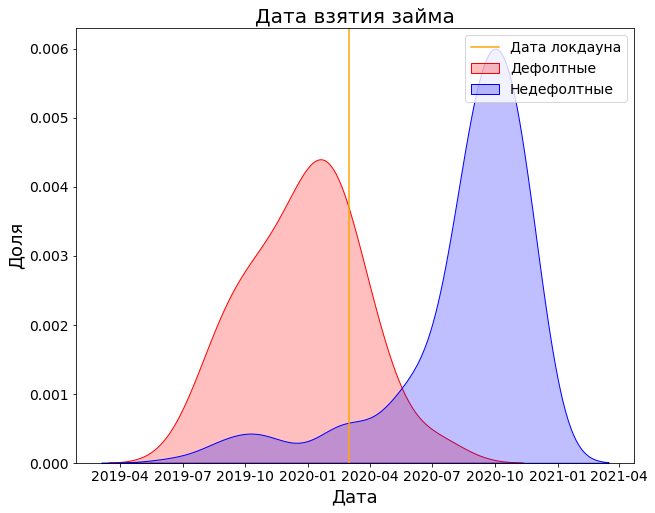

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.set_palette("bright", 10)
sns.kdeplot(data_order[data_order.is_default == 1]["loan_issue_dt"], shade=True, color="red", label="Дефолтные")
sns.kdeplot(data_order[data_order.is_default == 0]["loan_issue_dt"], shade=True, color="blue", label="Недефолтные")

ax.set_ylabel('Доля', fontsize=18)
ax.set_title('Дата взятия займа', fontsize=20)
ax.set_xlabel('Дата', fontsize=18)

covid_date = pd.Timestamp(year=2020, month=3, day=1)
plt.axvline(x=covid_date, color="orange", label="Дата локдауна")
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Плотность_дата_займа.jpg", bbox_inches = 'tight')

In [19]:
data_order["year"] = data_order.loan_issue_dt.apply(lambda row: row.year)
data_order["month"] = data_order.loan_issue_dt.apply(lambda row: row.month)

data_order["short_date"] = \
    data_order.year.apply(str) + '-' + data_order.month.apply(lambda month: str(month) if month >= 10 else '0' + str(month))

amount_per_month = data_order.groupby(["short_date"]).loan_principal.sum() / 1000000

In [20]:
def_count_per_month = data_order.groupby(["short_date"]).is_default.sum()
non_def_count_per_month = data_order.groupby(["short_date"]).is_default.agg(lambda x: x.count() - x.sum())

In [21]:
def multiply_items(l):
    return [i for t in zip(l,l) for i in t]

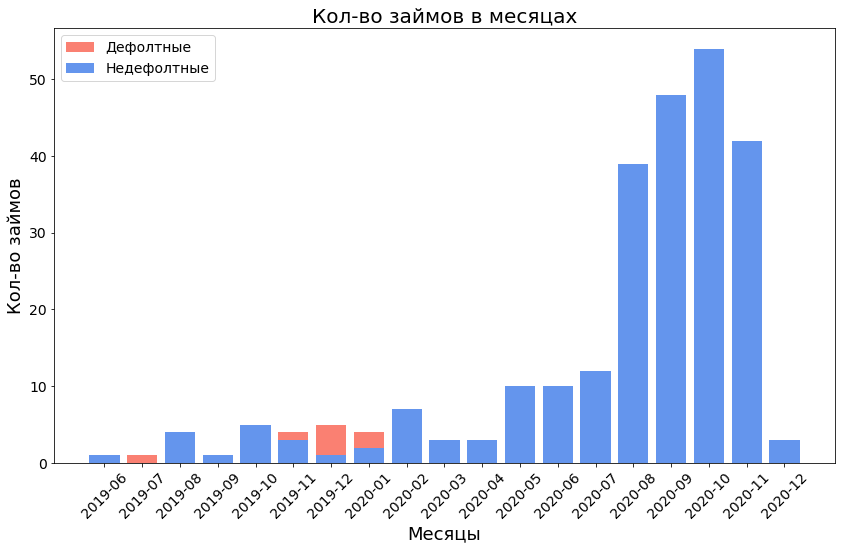

In [22]:
fig, ax = plt.subplots(figsize=(14, 8))

height = def_count_per_month
 
bars = def_count_per_month.index
y_pos = np.arange(len(bars))
 
plt.bar(y_pos, height, color="salmon", label="Дефолтные")

height = non_def_count_per_month

plt.bar(y_pos, height, color="cornflowerblue", label="Недефолтные")

plt.xticks(y_pos, bars, rotation=45)

ax.set_ylabel('Кол-во займов', fontsize=18)
ax.set_xlabel('Месяцы', fontsize=18)
ax.set_title("Кол-во займов в месяцах", fontsize=20)
plt.legend(fontsize=14)

plt.tick_params(labelsize=14)

plt.savefig("Займы_месяцы.jpg", bbox_inches = 'tight')

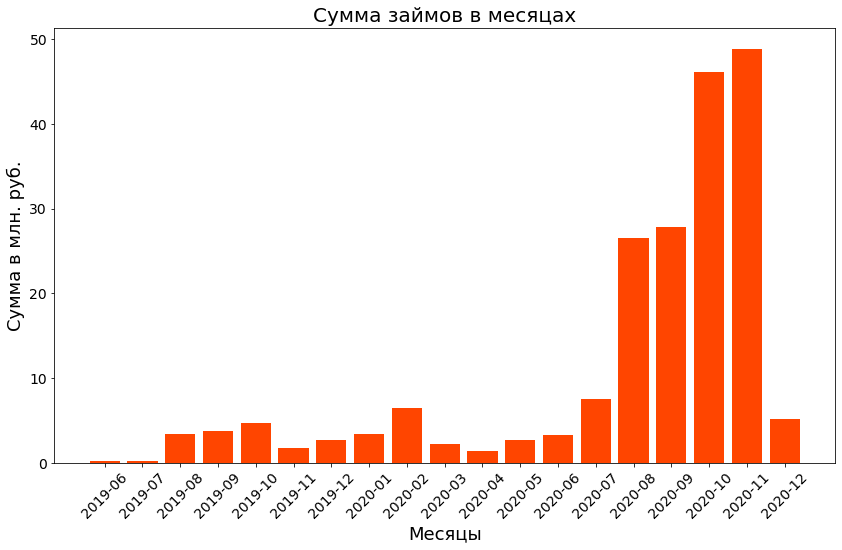

In [718]:
fig, ax = plt.subplots(figsize=(14, 8))

height = amount_per_month
 
bars = amount_per_month.index
y_pos = np.arange(len(bars))
 
plt.bar(y_pos, height, color="orangered")



plt.xticks(y_pos, bars, rotation=45)

ax.set_ylabel('Сумма в млн. руб.', fontsize=18)
ax.set_xlabel('Месяцы', fontsize=18)
ax.set_title("Сумма займов в месяцах", fontsize=20)


plt.tick_params(labelsize=14)

plt.savefig("Сумма_месяцы.jpg", bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, ax=ax)

plt.savefig("corr.jpg")

In [105]:
columns_for_correlations = ["industry_codename_1"]
tmp = contracts_df.industry_codename.str.split('.')
contracts_df["industry_codename_1"] = tmp.apply(lambda x: x[0])

In [109]:
corr = pd.get_dummies(contracts_df[columns_for_correlations]).corrwith(contracts_df.is_default)

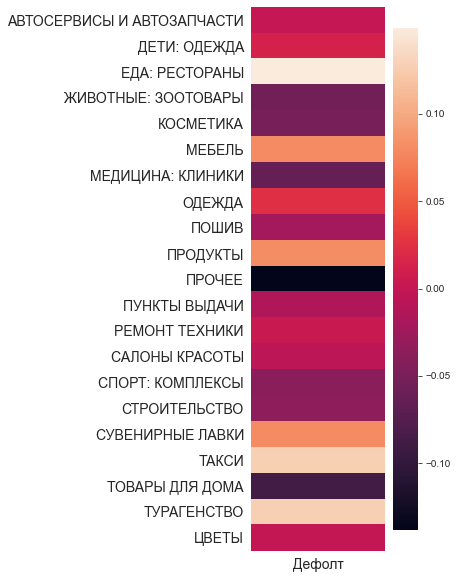

In [163]:
fig, ax = plt.subplots(figsize=(3,10))

sns.heatmap(corr.values[:, None], 
        xticklabels=["Дефолт"],
        yticklabels=corr.reset_index()["index"].apply(lambda name: name.split("industry_codename_1_")[1]),\
            ax=ax)
plt.tick_params(labelsize=14)

plt.savefig("Корреляции.jpg", bbox_inches = 'tight')

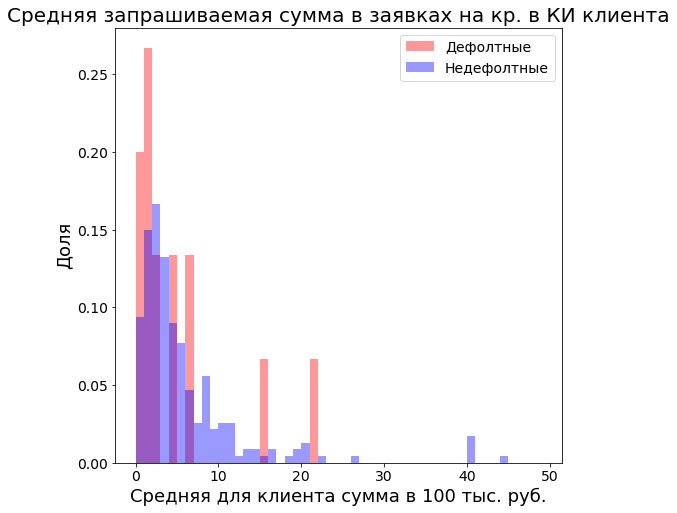

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))

# sns.set_palette("bright", 10)
# sns.kdeplot(data_order[(data_order.is_default == 1) & (data_order.mean_rejected_amount != 1) & (data_order.mean_rejected_amount < 5000000)]["mean_rejected_amount"] / 1000000, bw=0.5, shade=True, color="red", label="Дефолтные")
# sns.kdeplot(data_order[(data_order.is_default == 0) & (data_order.mean_rejected_amount != 1) & (data_order.mean_rejected_amount < 5000000)]["mean_rejected_amount"] / 1000000, bw=0.5, shade=True, color="blue", label="Недефолтные")

sns.distplot(data_order[(data_order.is_default == 1) & (data_order.mean_rejected_amount != 1) & (data_order.mean_rejected_amount < 5000000)]["mean_rejected_amount"] / 100000, \
             kde=False, hist=True, bins=np.arange(0, 50, 1), color="red", label="Дефолтные", ax=ax, norm_hist=True)
sns.distplot(data_order[(data_order.is_default == 0) & (data_order.mean_rejected_amount != 1) & (data_order.mean_rejected_amount < 5000000)]["mean_rejected_amount"] / 100000, \
             kde=False, hist=True, bins=np.arange(0, 50, 1), color="blue", label="Недефолтные", ax=ax, norm_hist=True)

ax.set_ylabel('Доля', fontsize=18)    
ax.set_title('Средняя запрашиваемая сумма в заявках на кр. в КИ клиента', fontsize=20)
ax.set_xlabel('Средняя для клиента сумма в 100 тыс. руб.', fontsize=18)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Плотность_сумма_заявки.jpg", bbox_inches = 'tight')

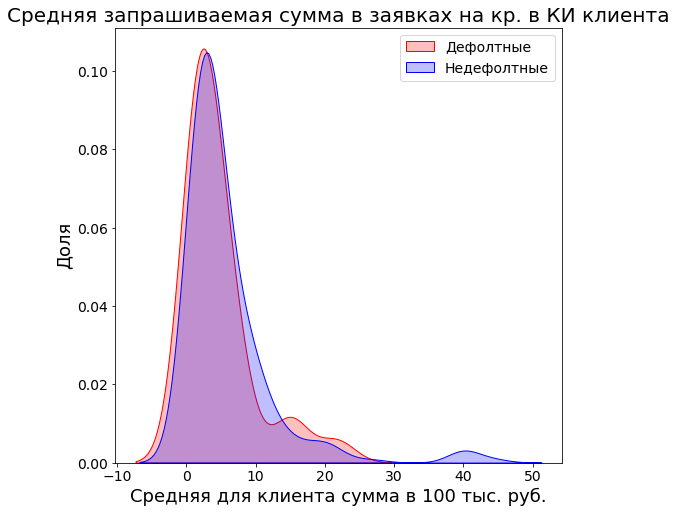

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))

# sns.set_palette("bright", 10)
sns.kdeplot(data_order[(data_order.is_default == 1) & (data_order.mean_rejected_amount != 1) & (data_order.mean_rejected_amount < 5000000)]["mean_rejected_amount"] / 100000, shade=True, color="red", label="Дефолтные")
sns.kdeplot(data_order[(data_order.is_default == 0) & (data_order.mean_rejected_amount != 1) & (data_order.mean_rejected_amount < 5000000)]["mean_rejected_amount"] / 100000, shade=True, color="blue", label="Недефолтные")

# sns.distplot(data_order[(data_order.is_default == 1) & (data_order.mean_rejected_amount != 1) & (data_order.mean_rejected_amount < 5000000)]["mean_rejected_amount"] / 100000, \
#              kde=False, hist=True, bins=np.arange(0, 50, 1), color="red", label="Дефолтные", ax=ax, norm_hist=True)
# sns.distplot(data_order[(data_order.is_default == 0) & (data_order.mean_rejected_amount != 1) & (data_order.mean_rejected_amount < 5000000)]["mean_rejected_amount"] / 100000, \
#              kde=False, hist=True, bins=np.arange(0, 50, 1), color="blue", label="Недефолтные", ax=ax, norm_hist=True)

ax.set_ylabel('Доля', fontsize=18)    
ax.set_title('Средняя запрашиваемая сумма в заявках на кр. в КИ клиента', fontsize=20)
ax.set_xlabel('Средняя для клиента сумма в 100 тыс. руб.', fontsize=18)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Плотность_сумма_заявки_.jpg", bbox_inches = 'tight')

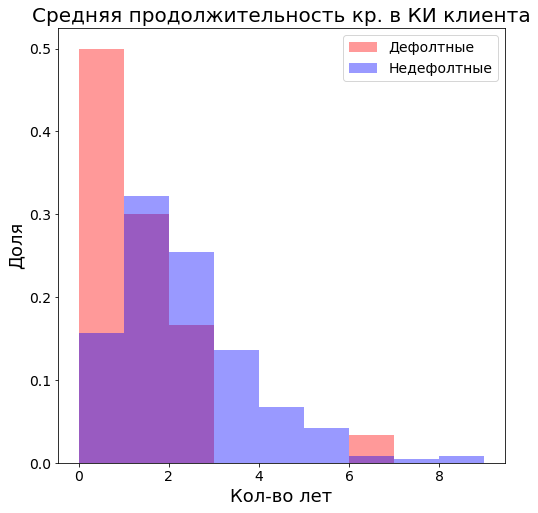

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.distplot(data_order[(data_order.is_default == 1) & (data_order.mean_duration_loan != 1)]["mean_duration_loan"] // 360, \
             kde=False, hist=True, bins=np.arange(0, 10, 1), color="red", label="Дефолтные", ax=ax, norm_hist=True)
sns.distplot(data_order[(data_order.is_default == 0) & (data_order.mean_duration_loan != 1)]["mean_duration_loan"] // 360, \
             kde=False, hist=True, bins=np.arange(0, 10, 1), color="blue", label="Недефолтные", ax=ax, norm_hist=True)

ax.set_ylabel('Доля', fontsize=18)
ax.set_title("Средняя продолжительность кр. в КИ клиента", fontsize=20)
ax.set_xlabel('Кол-во лет', fontsize=18)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Ср_продолж_кр_КИ.jpg", bbox_inches = 'tight')

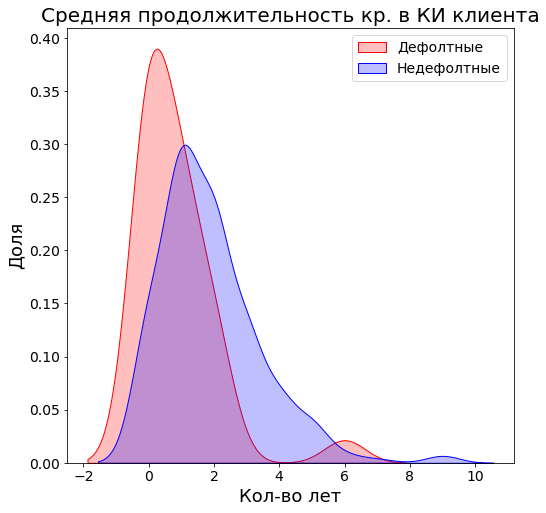

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.kdeplot(data_order[(data_order.is_default == 1) & (data_order.mean_duration_loan != 1)]["mean_duration_loan"] // 360, shade=True, color="red", label="Дефолтные")
sns.kdeplot(data_order[(data_order.is_default == 0) & (data_order.mean_duration_loan != 1)]["mean_duration_loan"] // 360, shade=True, color="blue", label="Недефолтные")

ax.set_ylabel('Доля', fontsize=18)
ax.set_title("Средняя продолжительность кр. в КИ клиента", fontsize=20)
ax.set_xlabel('Кол-во лет', fontsize=18)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Ср_продолж_кр_КИ_.jpg", bbox_inches = 'tight')

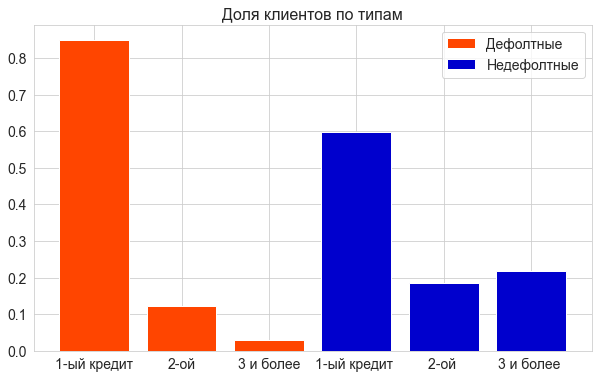

In [238]:
fig, ax = plt.subplots(figsize=(10, 6))

data["clientloantypetext"] = clientloantype_LabelEncoder.inverse_transform(data.clientloantype)

delimiter_def = data[data.is_default == 1].shape[0]
delimiter_non_def = data[data.is_default == 0].shape[0]

ax.bar(["1-ый кредит", "2-ой", "3 и более"], [data[data.clientloantypetext == "FIRSTLOAN"][data.is_default == 1].shape[0] / delimiter_def,
        data[data.clientloantypetext == "SECONDLOAN"][data.is_default == 1].shape[0] / delimiter_def,
        data[data.clientloantypetext == "THIRDORMORELOAN"][data.is_default == 1].shape[0] / delimiter_def], color = "orangered", label="Дефолтные")

ax.bar(["1-ый кредит ", "2-ой ", "3 и более "], [data[data.clientloantypetext == "FIRSTLOAN"][data.is_default == 0].shape[0] / delimiter_non_def,
        data[data.clientloantypetext == "SECONDLOAN"][data.is_default == 0].shape[0] / delimiter_non_def,
        data[data.clientloantypetext == "THIRDORMORELOAN"][data.is_default == 0].shape[0] / delimiter_non_def], color = "mediumblue", label="Недефолтные")

ax.set_title("Доля клиентов по типам", size=16)
plt.savefig("Тип клиентов.jpg", bbox_inches = 'tight')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)

plt.show()

data.drop(["clientloantypetext"], inplace=True, axis=1)

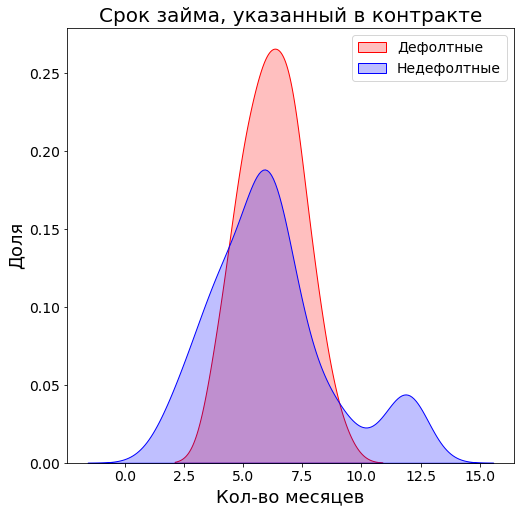

In [56]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.kdeplot(data_order[(data_order.is_default == 1)]["loan_terms_months"], shade=True, color="red", label="Дефолтные")
sns.kdeplot(data_order[(data_order.is_default == 0)]["loan_terms_months"], shade=True, color="blue", label="Недефолтные")

ax.set_ylabel('Доля', fontsize=18)    
ax.set_xlabel('Кол-во месяцев', fontsize=18)
ax.set_title("Срок займа, указанный в контракте", fontsize=20)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Срок_займа_.jpg", bbox_inches = 'tight')

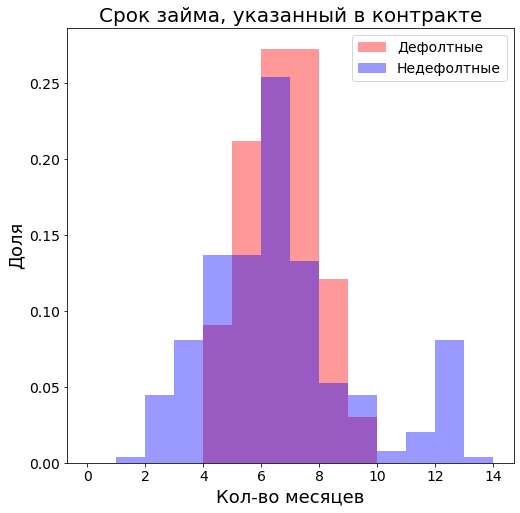

In [57]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.distplot(data_order[(data_order.is_default == 1)]["loan_terms_months"], \
             kde=False, hist=True, bins=np.arange(0, 15, 1), color="red", label="Дефолтные", ax=ax, norm_hist=True)
sns.distplot(data_order[(data_order.is_default == 0)]["loan_terms_months"], \
             kde=False, hist=True, bins=np.arange(0, 15, 1), color="blue", label="Недефолтные", ax=ax, norm_hist=True)

ax.set_ylabel('Доля', fontsize=18)    
ax.set_xlabel('Кол-во месяцев', fontsize=18)
ax.set_title("Срок займа, указанный в контракте", fontsize=20)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Срок_займа.jpg", bbox_inches = 'tight')

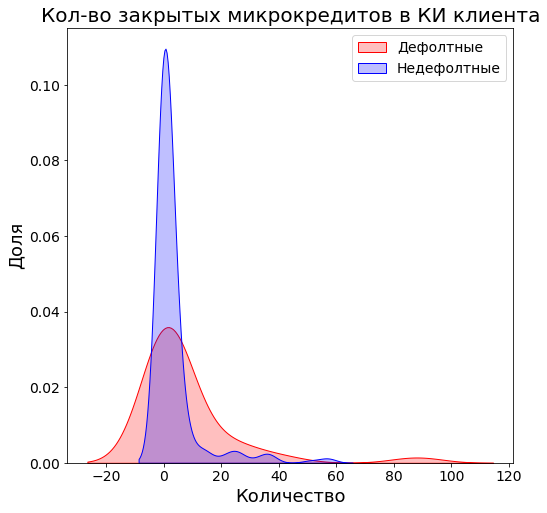

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.set_palette("bright", 10)
sns.kdeplot(data_order[(data_order.is_default == 1) & (data_order.count_closed_МИКРОКРЕДИТ < 150)]["count_closed_МИКРОКРЕДИТ"], shade=True, color="red", label="Дефолтные")
sns.kdeplot(data_order[(data_order.is_default == 0) & (data_order.count_closed_МИКРОКРЕДИТ < 150)]["count_closed_МИКРОКРЕДИТ"], shade=True, color="blue", label="Недефолтные")

ax.set_ylabel('Доля', fontsize=18)    
ax.set_xlabel('Количество', fontsize=18)
ax.set_title("Кол-во закрытых микрокредитов в КИ клиента", fontsize=20)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Кол_во_микрокредитов_.jpg", bbox_inches = 'tight')

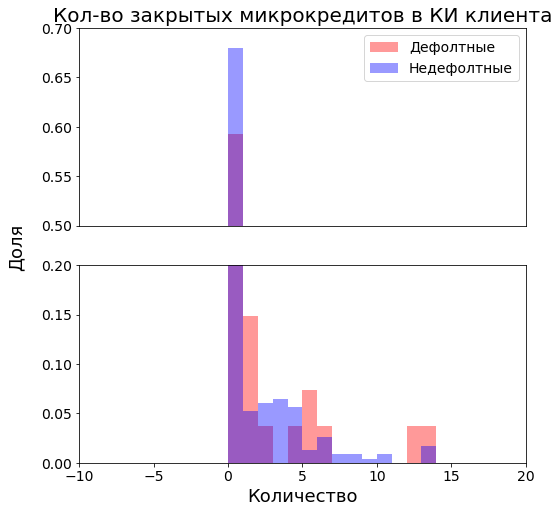

In [43]:
f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(8, 8))

sns.distplot(data_order[(data_order.is_default == 1) & (data_order.count_closed_МИКРОКРЕДИТ < 150)]["count_closed_МИКРОКРЕДИТ"], \
             kde=False, hist=True, bins=np.arange(0, 15, 1), color="red", label="Дефолтные", ax=ax2, norm_hist=True)
sns.distplot(data_order[(data_order.is_default == 1) & (data_order.count_closed_МИКРОКРЕДИТ < 150)]["count_closed_МИКРОКРЕДИТ"], \
             kde=False, hist=True, bins=np.arange(0, 15, 1), color="red", label="Дефолтные", ax=ax1, norm_hist=True)

sns.distplot(data_order[(data_order.is_default == 0) & (data_order.count_closed_МИКРОКРЕДИТ < 150)]["count_closed_МИКРОКРЕДИТ"], \
             kde=False, hist=True, bins=np.arange(0, 15, 1), color="blue", label="Недефолтные", ax=ax2, norm_hist=True, \
             kde_kws={"clip": (-10, 20)})
sns.distplot(data_order[(data_order.is_default == 0) & (data_order.count_closed_МИКРОКРЕДИТ < 150)]["count_closed_МИКРОКРЕДИТ"], \
             kde=False, hist=True, bins=np.arange(0, 15, 1), color="blue", label="Недефолтные", ax=ax1, norm_hist=True)

ax1.get_xaxis().set_visible(False)

ax1.set_ylabel("")
ax2.set_ylabel("")

ax1.set_ylim(0.5, 0.7)
ax2.set_ylim(0, 0.2)

ax1.set_xlim(-10, 20)
ax2.set_xlim(-10, 20)

f.text(0, 0.50, 'Доля', va='center', rotation='vertical', fontsize=18)

# then create a new legend and put it to the side of the figure (also requires trial and error)
ax1.legend(fontsize=14)

ax2.set_xlabel('Количество', fontsize=18)
ax1.set_title("Кол-во закрытых микрокредитов в КИ клиента", fontsize=20)

ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

plt.show()

f.savefig("Кол_во_микрокредитов.jpg", bbox_inches = 'tight')

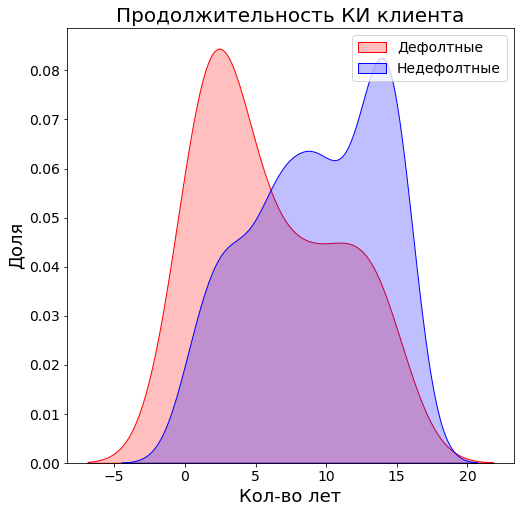

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.kdeplot(data_order[(data_order.is_default == 1)]["duration_loan_history"] / 360, shade=True, color="red", label="Дефолтные")
sns.kdeplot(data_order[(data_order.is_default == 0)]["duration_loan_history"] / 360, shade=True, color="blue", label="Недефолтные")

ax.set_ylabel('Доля', fontsize=18)    
ax.set_xlabel("Кол-во лет", fontsize=18)
ax.set_title("Продолжительность КИ клиента", fontsize=20)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Продолжительность_КИ_.jpg", bbox_inches = 'tight')

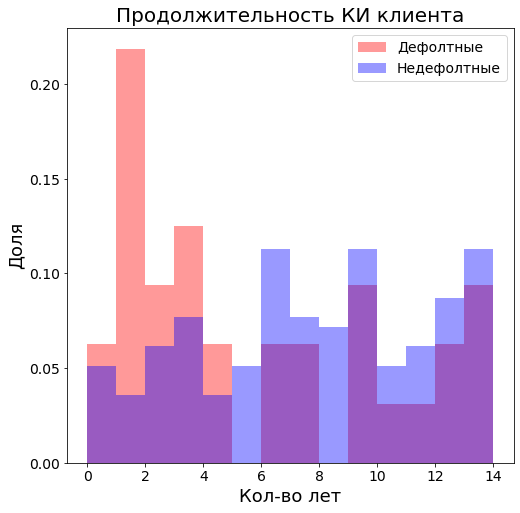

In [47]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.set_palette("bright", 10)

sns.distplot(data_order[(data_order.is_default == 1)]["duration_loan_history"] / 360, \
             kde=False, norm_hist=True, hist=True, bins=np.arange(0, 15, 1), color="red", label="Дефолтные", ax=ax)
sns.distplot(data_order[(data_order.is_default == 0)]["duration_loan_history"] / 360, \
             kde=False, norm_hist=True, hist=True, bins=np.arange(0, 15, 1), color="blue", label="Недефолтные", ax=ax)

ax.set_ylabel('Доля', fontsize=18)    
ax.set_xlabel("Кол-во лет", fontsize=18)
ax.set_title("Продолжительность КИ клиента", fontsize=20)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Продолжительность_КИ.jpg", bbox_inches = 'tight')

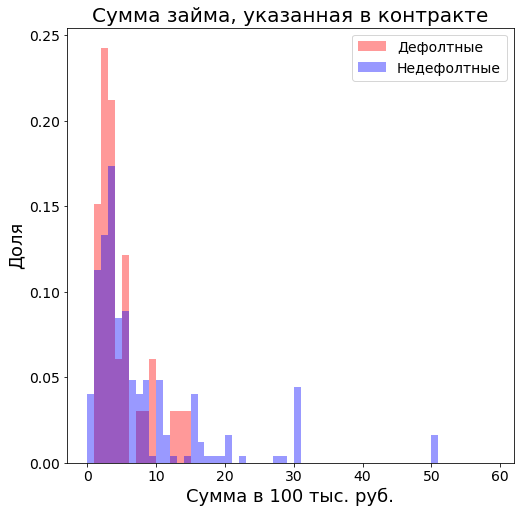

In [49]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.set_palette("bright", 10)

sns.distplot(data_order[(data_order.is_default == 1)]["loan_principal"] / 100000, \
             kde=False, norm_hist=True, hist=True, bins=np.arange(0, 60, 1), color="red", label="Дефолтные", ax=ax)
sns.distplot(data_order[(data_order.is_default == 0)]["loan_principal"] / 100000, \
             kde=False, norm_hist=True, hist=True, bins=np.arange(0, 60, 1), color="blue", label="Недефолтные", ax=ax)

ax.set_ylabel('Доля', fontsize=18)    
ax.set_xlabel('Сумма в 100 тыс. руб.', fontsize=18)
ax.set_title('Сумма займа, указанная в контракте', fontsize=20)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Сумма_займа.jpg", bbox_inches = 'tight')

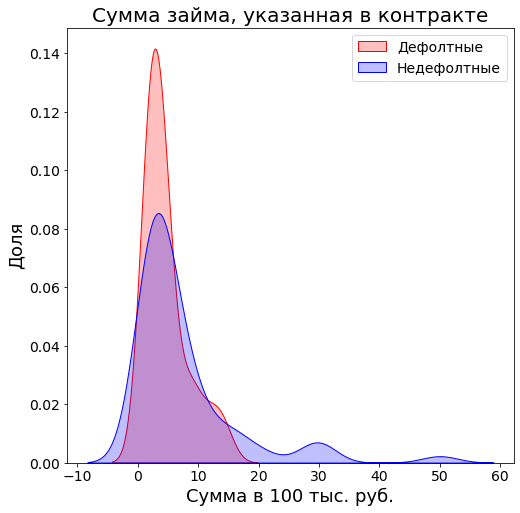

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))


sns.kdeplot(data_order[(data_order.is_default == 1)]["loan_principal"] / 100000, shade=True, color="red", label="Дефолтные")
sns.kdeplot(data_order[(data_order.is_default == 0)]["loan_principal"] / 100000, shade=True, color="blue", label="Недефолтные")

ax.set_ylabel('Доля', fontsize=18)    
ax.set_xlabel('Сумма в 100 тыс. руб.', fontsize=18)
ax.set_title('Сумма займа, указанная в контракте', fontsize=20)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Сумма_займа_.jpg", bbox_inches = 'tight')

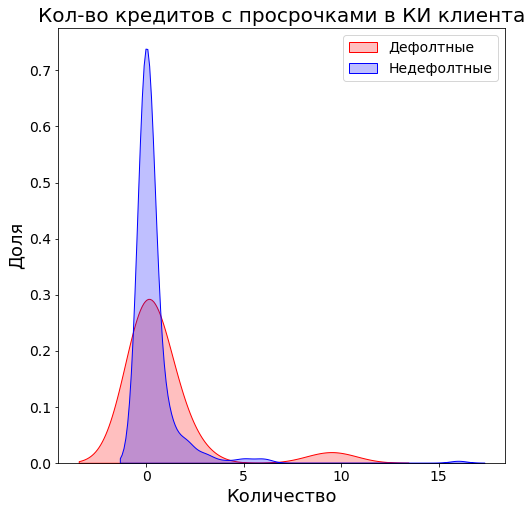

In [53]:
fig, ax = plt.subplots(figsize=(8, 8))

# sns.set_palette("bright", 10)
sns.kdeplot(data_order[(data_order.is_default == 1)]["count_loan_with_overdue"], shade=True, color="red", label="Дефолтные")
sns.kdeplot(data_order[(data_order.is_default == 0)]["count_loan_with_overdue"], shade=True, color="blue", label="Недефолтные")

# sns.distplot(data_order[(data_order.is_default == 1)]["count_loan_with_overdue"], \
#              kde=False, norm_hist=True, hist=True, bins=np.arange(0, 15, 1), color="red", label="Дефолтные", ax=ax)
# sns.distplot(data_order[(data_order.is_default == 0)]["count_loan_with_overdue"], \
#              kde=False, norm_hist=True, hist=True, bins=np.arange(0, 15, 1), color="blue", label="Недефолтные", ax=ax)

ax.set_ylabel('Доля', fontsize=18)    
ax.set_title('Кол-во кредитов с просрочками в КИ клиента', fontsize=20)
ax.set_xlabel('Количество', fontsize=18)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Просрочки_.jpg", bbox_inches = 'tight')

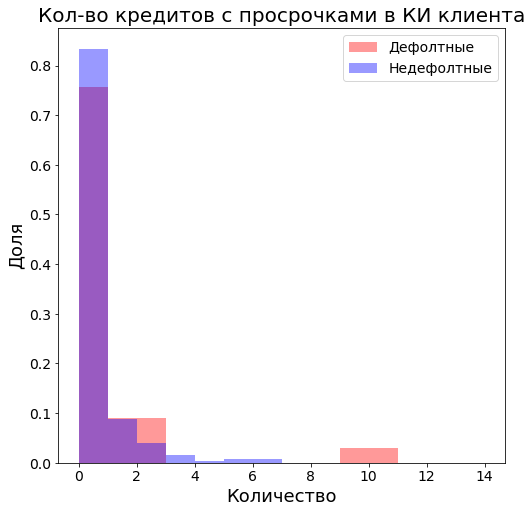

In [54]:
fig, ax = plt.subplots(figsize=(8, 8))

# sns.set_palette("bright", 10)
# sns.kdeplot(data_order[(data_order.is_default == 1)]["count_loan_with_overdue"], shade=True, color="red", label="Дефолтные")
# sns.kdeplot(data_order[(data_order.is_default == 0)]["count_loan_with_overdue"], shade=True, color="blue", label="Недефолтные")

sns.distplot(data_order[(data_order.is_default == 1)]["count_loan_with_overdue"], \
             kde=False, norm_hist=True, hist=True, bins=np.arange(0, 15, 1), color="red", label="Дефолтные", ax=ax)
sns.distplot(data_order[(data_order.is_default == 0)]["count_loan_with_overdue"], \
             kde=False, norm_hist=True, hist=True, bins=np.arange(0, 15, 1), color="blue", label="Недефолтные", ax=ax)

ax.set_ylabel('Доля', fontsize=18)    
ax.set_title('Кол-во кредитов с просрочками в КИ клиента', fontsize=20)
ax.set_xlabel('Количество', fontsize=18)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Просрочки.jpg", bbox_inches = 'tight')

In [350]:
# fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# ax[0].scatter(list(range(data_order[data_order.is_default == 1].shape[0])), \
#             data_order[data_order.is_default == 1].loan_issue_dt, s=data_order[data_order.is_default == 1].loan_principal,\
#               c="red", alpha=0.4, edgecolors="grey", linewidth=2)

# ax[1].scatter(list(range(data_order[data_order.is_default == 0].shape[0])), \
#             data_order[data_order.is_default == 0].loan_issue_dt, s=data_order[data_order.is_default == 0].loan_principal, \
#               c="blue", alpha=0.4, edgecolors="grey", linewidth=2)


# plt.savefig(".jpg")

In [45]:
print_series(data.loc[0])

application_id  -  261
loan_principal  -  368900.0
loan_terms_months  -  7
loan_issue_dt  -  2019-12-26 00:00:00
clientloantype  -  0
is_default  -  1
industry_codename_1  -  9
diff_loan_issue_dt_last_loan  -  147
duration_loan_history  -  2273
mean_duration_loan  -  598.5
count_loan_with_overdue  -  0
count_closed_МИКРОКРЕДИТ  -  0
count_closed_ПОТРЕБИТ.КРЕДИТ  -  4
count_closed_КРЕДИТНАЯ КАРТА  -  4
count_closed_АВТОКРЕДИТ  -  3
count_closed_НА УВЕЛИЧЕНИЕ ОБОРОТА  -  0
count_closed_НА РАЗВИТИЕ БИЗНЕСА  -  0
count_closed_ИПОТЕКА  -  0
count_closed_ОВЕРДРАФТ  -  0
count_closed_ЛИЗИНГ  -  0
mean_rejected_amount  -  1.0


### Модель

In [10]:
def eval_metrics(data, model, func_prepare_features, threshold=0.5, f1_beta=0.5, n_splits=3, count_experiments=50):
    metrics = {"auc": [], "gini": [], "P": [], "R": [], "F1": [], "accuracy": [], "balance_acc" : []}
    for step in range(count_experiments):
        kf = KFold(n_splits=n_splits, shuffle=True)
        kf.get_n_splits(data)
        list_precision = []
        list_recall = []
        list_f1_score = []
        list_auc_roc_score = []
        list_gini = []
        list_acc = []
        list_balance_acc = []
        for train_index, test_index in kf.split(data):
            train_data, test_data = data.iloc[train_index, :], data.iloc[test_index, :]
            _, X_train, y_train = func_prepare_features(train_data)
            clf = model()
            clf.fit(X_train, y_train)
            _, X_test, y_test = func_prepare_features(test_data)
            y_pred = clf.predict(X_test)
            list_precision.append(precision_score(y_test, (pd.Series(y_pred) > threshold).astype("int64")))
            list_recall.append(recall_score(y_test, (pd.Series(y_pred) > threshold).astype("int64")))
            list_f1_score.append(fbeta_score(y_test, (pd.Series(y_pred) > threshold).astype("int64"), beta=f1_beta))
            list_auc_roc_score.append(roc_auc_score(y_test, y_pred))
            list_gini.append(2 * roc_auc_score(y_test, y_pred) - 1)
            list_acc.append(accuracy_score(y_test, (pd.Series(y_pred) > threshold).astype("int64")))
            list_balance_acc.append(balanced_accuracy_score(y_test, (pd.Series(y_pred) > threshold).astype("int64")))

        metrics["auc"].append(np.mean(list_auc_roc_score))
        metrics["gini"].append(np.mean(list_gini))
        metrics["F1"].append(np.mean(list_f1_score))
        metrics["P"].append(np.mean(list_precision))
        metrics["R"].append(np.mean(list_recall))
        metrics["accuracy"].append(np.mean(list_acc))
        metrics["balance_acc"].append(np.mean(list_balance_acc))
        
    return metrics.copy()

In [11]:
def simple_prepare(data):
    prepared_data = data.copy()
    prepared_data.loan_principal = np.log(prepared_data.loan_principal)
    prepared_data.diff_loan_issue_dt_last_loan = np.log(prepared_data.diff_loan_issue_dt_last_loan)
#     prepared_data.duration_loan_history = \
#         StandardScaler().fit_transform(prepared_data.duration_loan_history.to_numpy()[:, None])
    prepared_data.mean_duration_loan = np.log(prepared_data.mean_duration_loan)
    prepared_data.mean_rejected_amount = np.log(prepared_data.mean_rejected_amount)
    
    X = data.iloc[:, (data.columns != "application_id") & (data.columns != "is_default") & 
                  (data.columns != "loan_issue_dt") & (data.columns != "product_group_codename")]
    X = X.values
    y = data.is_default
    
    return (prepared_data, X, y)

In [12]:
import lightgbm as lgb
from sklearn.base import BaseEstimator, ClassifierMixin

In [13]:
class djLGB(BaseEstimator, ClassifierMixin):  

    def __init__(self, seed=0, nest_lgb=1.0, cbt=0.5, ss=0.5, alpha=0.6):
        #print('LGB')
        self.models = [lgb.LGBMClassifier(num_leaves=2, learning_rate=0.07, n_estimators=int(140*nest_lgb),
                                          colsample_bytree=cbt, subsample=ss, random_state=0+seed, verbose=-1),
                       lgb.LGBMClassifier(num_leaves=3, learning_rate=0.07, n_estimators=int(80*nest_lgb),
                                          colsample_bytree=cbt, subsample=ss, random_state=1+seed, verbose=-1)
                      ]
        self.weights = [alpha, (1 - alpha)]


    def fit(self, X, y=None):
        fit_params={'verbose': 100,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }
        for t, clf in enumerate(self.models):
            # print ('train', t)
            clf.fit(X, y, **fit_params)
        return self

    def predict(self, X):
        suma = 0.0
        for t, clf in enumerate(self.models):
            a = clf.predict_proba(X)[:, 1]
            suma += (self.weights[t] * a)
        return (suma / sum(self.weights))
            
    def predict_proba(self, X):     
        return (self.predict(X))
    
    def predict_with_threshold(self, X, threshold):
        return self.predict(X) > threshold

In [14]:
prepared_data, X, y = simple_prepare(data)
prepared_data

,application_id,loan_principal,loan_terms_months,loan_issue_dt,clientloantype,is_default,product_group_codename,industry_codename_1,diff_loan_issue_dt_last_loan,duration_loan_history,...,count_closed_МИКРОКРЕДИТ,count_closed_ПОТРЕБИТ.КРЕДИТ,count_closed_КРЕДИТНАЯ КАРТА,count_closed_АВТОКРЕДИТ,count_closed_НА УВЕЛИЧЕНИЕ ОБОРОТА,count_closed_НА РАЗВИТИЕ БИЗНЕСА,count_closed_ИПОТЕКА,count_closed_ОВЕРДРАФТ,count_closed_ЛИЗИНГ,mean_rejected_amount
0,261,12.818281,7,2019-12-26,0,1,PF-Аванс,8,4.990433,2273,...,0,4,4,3,0,0,0,0,0,13.077353
2,167,13.997832,7,2019-12-26,2,1,PF-Аванс,7,5.899897,1548,...,4,0,0,2,0,0,0,0,0,14.588980
3,9210,14.038654,8,2020-10-20,1,0,PF-Аванс,9,3.637586,1207,...,0,1,3,1,1,0,0,0,0,13.925664
4,1061,13.592367,7,2020-09-03,0,0,PF-Аванс,8,3.465736,314,...,0,0,0,0,0,0,0,0,0,13.199097
7,9117,11.695247,5,2020-10-21,1,0,PF-Аванс,9,4.779123,2245,...,3,5,2,0,0,0,0,0,0,13.157324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,6052,13.620711,4,2020-10-08,0,0,PF-Аванс,9,2.197225,5547,...,23,120,28,0,0,4,0,0,0,13.803251
276,4094,12.287653,8,2020-08-20,0,0,PF-Аванс,2,5.602119,271,...,0,0,0,0,0,0,0,0,0,13.140531
278,8975,14.914123,5,2020-10-08,2,0,PF-Аванс,8,5.966147,5105,...,1,14,2,1,1,7,0,0,0,13.017017
279,1365,14.185556,7,2020-02-21,1,1,PF-Аванс,8,3.663562,480,...,41,0,1,0,0,0,0,0,0,12.464053


In [15]:
import pickle

In [16]:
train_data, test_data = train_test_split(data, test_size=0.4, random_state=5)

In [124]:
prepared_train_data, X_train, y_train = simple_prepare(train_data)

In [16]:
model = djLGB()
model.fit(X, y)

djLGB(alpha=None, cbt=None, nest_lgb=None, seed=None, ss=None)

In [17]:
f = open("model.sav", 'wb')
pickle.dump(model, f)
f.close()

In [20]:
prepared_test_data, X_test, y_test = simple_prepare(test_data)

In [21]:
y_pred = model.predict(X_test)

In [22]:
precision_score(y_test, model.predict_with_threshold(X_test, 0.6))

0.0

In [23]:
2 * roc_auc_score(y_test, y_pred) - 1

0.7867803837953091

### Выигрыш и потери от модели

In [471]:
profit = pd.DataFrame(columns=["threshold", "loses", "wins", "current_loses"])

In [472]:
for threshold in np.arange(0, 1, 0.01):
    data["pred_t"] = (y_pred > threshold)
    loses = data[(data.is_default == 0) & (data.pred_t == 1)].loan_principal.sum() + \
        data[(data.is_default == 1) & (data.pred_t == 0)].loan_principal.sum()
    wins = data[(data.is_default == 1) & (data.pred_t == 1)].loan_principal.sum()
    current_loses = data[(data.is_default == 1)].loan_principal.sum()
    profit = profit.append(pd.DataFrame([[threshold, loses, wins, current_loses]], \
                                        columns = ["threshold", "loses", "wins", "current_loses"]))

In [474]:
profit[profit.threshold == 0.6]

,threshold,loses,wins,current_loses
0,0.6,8913280.0,6271309.2,15034589.2


In [476]:
profit.to_csv("loses.csv", index=False)

In [786]:
data.to_csv("data.csv", index=False)

In [792]:
data.columns

Index(['application_id', 'loan_principal', 'loan_terms_months',
       'loan_issue_dt', 'clientloantype', 'is_default', 'industry_codename_1',
       'diff_loan_issue_dt_last_loan', 'duration_loan_history',
       'mean_duration_loan', 'count_loan_with_overdue', 'is_person',
       'count_closed_МИКРОКРЕДИТ', 'count_closed_ПОТРЕБИТ.КРЕДИТ',
       'count_closed_КРЕДИТНАЯ КАРТА', 'count_closed_АВТОКРЕДИТ',
       'count_closed_НА УВЕЛИЧЕНИЕ ОБОРОТА',
       'count_closed_НА РАЗВИТИЕ БИЗНЕСА', 'count_closed_ИПОТЕКА',
       'count_closed_ОВЕРДРАФТ', 'count_closed_ЛИЗИНГ', 'mean_rejected_amount',
       'score'],
      dtype='object')

In [805]:
data_ = data.copy()

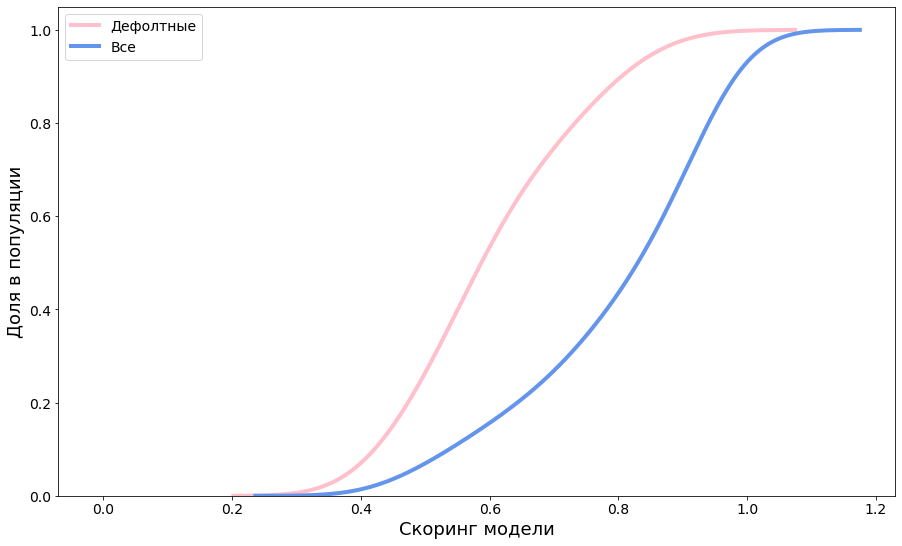

In [24]:
fig, ax = plt.subplots(figsize=(15, 9))

# sns.ecdfplot(pd.DataFrame(data=[[x, y] for x, y in zip(y_pred, y_test.apply(lambda x: "Дефолтные" if x == 1 else "Все"))], \
#              columns=["Скоринг", "Объекты"]), x="Скоринг", hue="Объекты", ax=ax, linewidth=4, \
#              palette={"Все": "cornflowerblue", "Дефолтные": "Pink"})

sns.kdeplot((1 - y_pred)[y_test == 1], cumulative=True, color="pink", label="Дефолтные", linewidth=4)
sns.kdeplot((1 - y_pred), cumulative=True, color="cornflowerblue", label="Все", linewidth=4)

# sns.distplot(y_pred[y_test == 1], rug=True, ax=ax)

# sns.histplot(y_pred, cumulative=True, ax=ax)

ax.set_ylabel('Доля в популяции', fontsize=18)    
ax.set_xlabel('Скоринг модели', fontsize=18)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.xlim(-0.07, 1.23)

plt.savefig("Распред_скоринг.jpg", bbox_inches = 'tight')
plt.show()

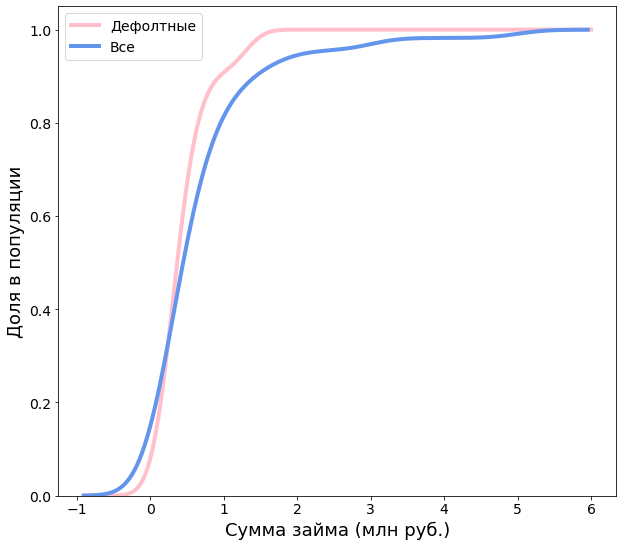

In [83]:
fig, ax = plt.subplots(figsize=(10, 9))

# sns.ecdfplot(pd.DataFrame(data=[[x, y] for x, y in zip(test_data.loan_principal / 1000000, y_test.apply(lambda x: "Дефолтные" if x == 1 else "Все"))], \
#              columns=["Скоринг", "Объекты"]), x="Скоринг", hue="Объекты", ax=ax, linewidth=4, \
#              palette={"Все": "cornflowerblue", "Дефолтные": "Pink"})

sns.kdeplot(test_data[test_data.is_default == 1].loan_principal / 1000000, cumulative=True, color="pink", label="Дефолтные", \
            linewidth=4, ax=ax, cut=25, clip=(-0.9, 6))
sns.kdeplot(test_data.loan_principal / 1000000, cumulative=True, color="cornflowerblue", label="Все", linewidth=4, ax=ax)

ax.set_ylabel('Доля в популяции', fontsize=18)    
ax.set_xlabel('Сумма займа (млн руб.)', fontsize=18)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Заспред_займ.jpg", bbox_inches = 'tight')
plt.show()

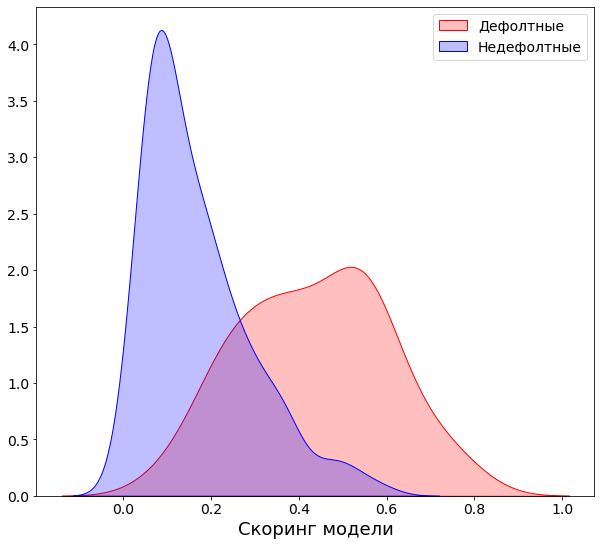

In [65]:
fig, ax = plt.subplots(figsize=(10, 9))

sns.set_palette("bright", 10)
sns.kdeplot(y_pred[y_test==1], shade=True, color="red", label="Дефолтные")
sns.kdeplot(y_pred[y_test==0], shade=True, color="blue", label="Недефолтные")

ax.set_ylabel('')    
ax.set_xlabel('Скоринг модели', fontsize=18)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Вер.jpg", bbox_inches = 'tight')

In [26]:
y_pred[y_test == 0]

array([0.09029532, 0.10106752, 0.12679162, 0.06259279, 0.5562648 ,
       0.02170442, 0.1226866 , 0.10472012, 0.08016957, 0.24975723,
       0.18096679, 0.78537102, 0.11223994, 0.52357576, 0.05130709,
       0.07749828, 0.69906511, 0.06128407, 0.22526878, 0.23769773,
       0.17662981, 0.07328443, 0.5197684 , 0.32693759, 0.06905325,
       0.39370433, 0.22933514, 0.45086779, 0.19248943, 0.18472154,
       0.39876724, 0.45505275, 0.20589451, 0.09741241, 0.05694619,
       0.05574566, 0.07820753, 0.103699  , 0.05510407, 0.12349301,
       0.04858895, 0.11839609, 0.47699101, 0.02338817, 0.23474844,
       0.30917263, 0.4611044 , 0.14771724, 0.05745499, 0.51961061,
       0.23293677, 0.36844539, 0.23190009, 0.13360545, 0.02338817,
       0.18220773, 0.30403044, 0.15541833, 0.09823563, 0.05683994,
       0.05790365, 0.440749  , 0.11194775, 0.22502301, 0.19549003,
       0.04969426, 0.18807384])

In [27]:
def hold_eval_metrics(data, model, func_prepare_features, threshold=0.6, f1_beta=0.5, test_size=0.4, count_experiments=50):
    metrics = {"auc": [], "gini": [], "P": [], "R": [], "F1": [], "accuracy": [], "balance_acc" : [], "report": []}
    for step in range(count_experiments):
        train_data, test_data = train_test_split(data, test_size=test_size, random_state=step)
        _, X_train, y_train = func_prepare_features(train_data)
        model = djLGB()
        model.fit(X_train, y_train)
        _, X_test, y_test = func_prepare_features(test_data)
        y_pred = model.predict(X_test)

        metrics["auc"].append(roc_auc_score(y_test, y_pred))
        metrics["gini"].append(2 * roc_auc_score(y_test, y_pred) - 1)
        metrics["F1"].append(fbeta_score(y_test, (pd.Series(y_pred) > threshold).astype("int64"), beta=f1_beta))
        metrics["P"].append(precision_score(y_test, (pd.Series(y_pred) > threshold).astype("int64")))
        metrics["R"].append(recall_score(y_test, (pd.Series(y_pred) > threshold).astype("int64")))
        metrics["accuracy"].append(accuracy_score(y_test, (pd.Series(y_pred) > threshold).astype("int64")))
        metrics["balance_acc"].append(balanced_accuracy_score(y_test, (pd.Series(y_pred) > threshold).astype("int64")))
        metrics["report"].append(classification_report(y_test, (pd.Series(y_pred) > threshold).astype("int64"), output_dict=True))
        
        
    return metrics.copy()

In [28]:
%%time
# Fit threshold
threshold_hist = []
metrics_hist = []

for threshold in np.arange(0, 1, 0.01):
    print(threshold)
    threshold_hist.append(threshold)
    metrics = hold_eval_metrics(data, djLGB, simple_prepare, threshold=threshold, f1_beta=0.5, test_size=0.4, count_experiments=10)
    metrics_hist.append(metrics)

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42
0.43
0.44
0.45
0.46
0.47000000000000003
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.96
0.97
0.98
0.99
Wall time: 1min 35s


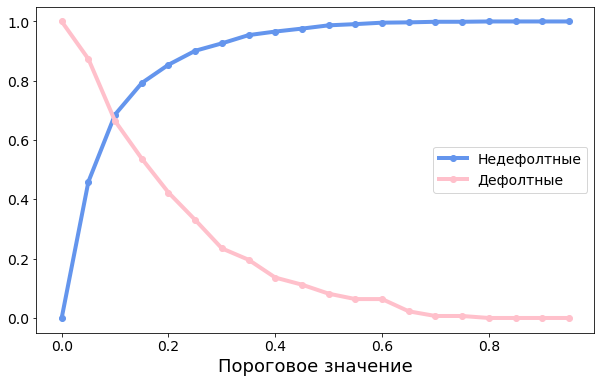

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(np.arange(0, 1, 0.05), [np.mean([m['0']["recall"] for m in metrics["report"]]) for metrics in metrics_hist], label="Недефолтные", \
         linewidth=4, marker='o', color = "cornflowerblue")
plt.plot(np.arange(0, 1, 0.05), [np.mean(metrics["R"]) for metrics in metrics_hist], label="Дефолтные", \
         linewidth=4, marker='o', color="Pink")
plt.xlabel("Пороговое значение", fontsize=18)
plt.legend()
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
#plt.savefig("metrics_hold.jpg", bbox_inches = 'tight')
plt.show()

In [ ]:
ax.set_ylabel('')    
ax.set_xlabel('Кол-во кредитов с просрочками в КИ', fontsize=18)

plt.legend(fontsize=14)
plt.tick_params(labelsize=14)

plt.savefig("Просрочки.jpg", bbox_inches = 'tight')

In [40]:
%%time
# Fit threshold
best_auc = 0
best_threshold = 0
threshold_hist = []
metrics_hist = []

for threshold in np.arange(0, 1, 0.01):
    print(threshold)
    threshold_hist.append(threshold)
    metrics = eval_metrics(data, djLGB, simple_prepare, threshold=threshold, f1_beta=0.5, \
                                     n_splits=3, count_experiments=10)
    metrics_hist.append(metrics)

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42
0.43
0.44
0.45
0.46
0.47000000000000003
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.96
0.97
0.98
0.99
Wall time: 2min 52s


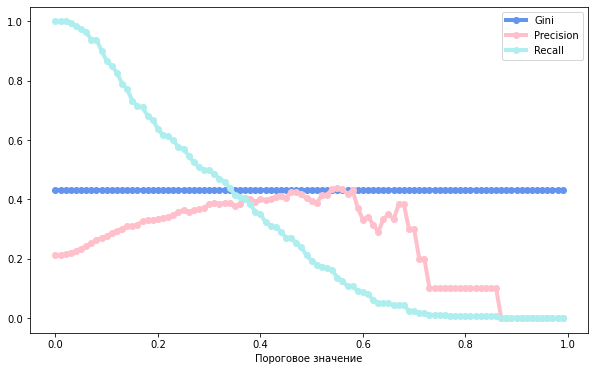

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(np.arange(0, 1, 0.01), [np.mean(metrics["gini"]) for metrics in metrics_hist], label="Gini", \
         linewidth=4, marker='o', color = "cornflowerblue")
plt.plot(np.arange(0, 1, 0.01), [np.mean(metrics["P"]) for metrics in metrics_hist], label="Precision", \
         linewidth=4, marker='o', color="Pink")
plt.plot(np.arange(0, 1, 0.01), [np.mean(metrics["R"]) for metrics in metrics_hist], label="Recall", \
         linewidth=4, marker='o', color="paleturquoise")
plt.xlabel("Пороговое значение")
plt.legend()
plt.show()

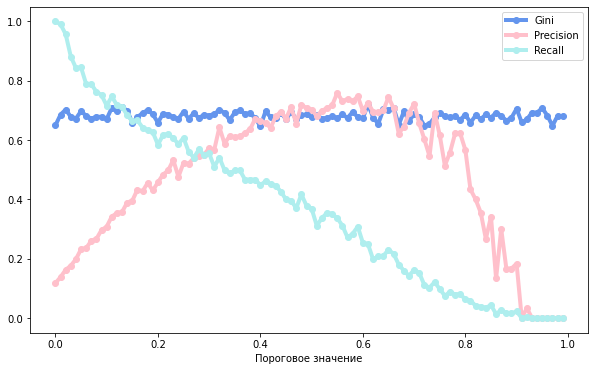

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(np.arange(0, 1, 0.01), [np.mean(metrics["gini"]) for metrics in metrics_hist], label="Gini", \
         linewidth=4, marker='o', color = "cornflowerblue")
plt.plot(np.arange(0, 1, 0.01), [np.mean(metrics["P"]) for metrics in metrics_hist], label="Precision", \
         linewidth=4, marker='o', color="Pink")
plt.plot(np.arange(0, 1, 0.01), [np.mean(metrics["R"]) for metrics in metrics_hist], label="Recall", \
         linewidth=4, marker='o', color="paleturquoise")
plt.xlabel("Пороговое значение")
plt.legend()
plt.savefig("metrics.jpg")
plt.show()

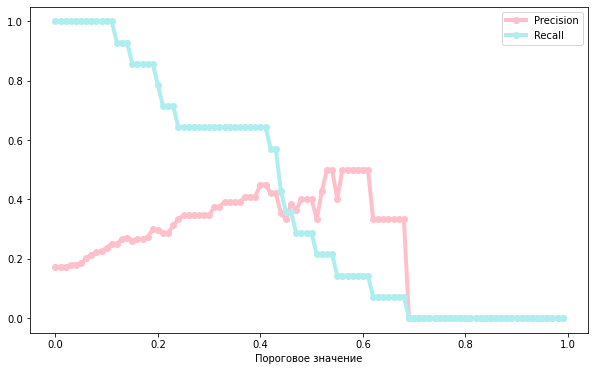

In [139]:
xs = np.arange(0, 1, 0.01)
ps = []
rs = []
accs = []
for x in xs:
    ps.append(precision_score(y_test, (pd.Series(y_pred) > x).astype("int64")))
    rs.append(recall_score(y_test, (pd.Series(y_pred) > x).astype("int64")))
    accs.append(accuracy_score(y_test, (pd.Series(y_pred) > x).astype("int64")))
    
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(np.arange(0, 1, 0.01), ps, label="Precision", \
         linewidth=4, marker='o', color="Pink")
plt.plot(np.arange(0, 1, 0.01), rs, label="Recall", \
         linewidth=4, marker='o', color="paleturquoise")

plt.xlabel("Пороговое значение")
plt.legend()
plt.savefig("metrics2.jpg")
plt.show()

In [140]:
max(accs)

0.8271604938271605

In [142]:
accs.index(0.8271604938271605)

53

In [138]:
xs[53]

0.53

In [143]:
index = 53
print("Max accuracy is equal ", accs[53])
print("Max presicion is equal ", ps[53])

Max accuracy is equal  0.8271604938271605
Max presicion is equal  0.5


In [68]:
len(y_pred)

201

### Feature importance

In [53]:
model = djLGB()

In [56]:
model.fit(rename_feature(prepared_data).drop(["application_id", "is_default", "loan_issue_dt"], axis=1), y)

djLGB(alpha=None, cbt=None, nest_lgb=None, seed=None, ss=None)

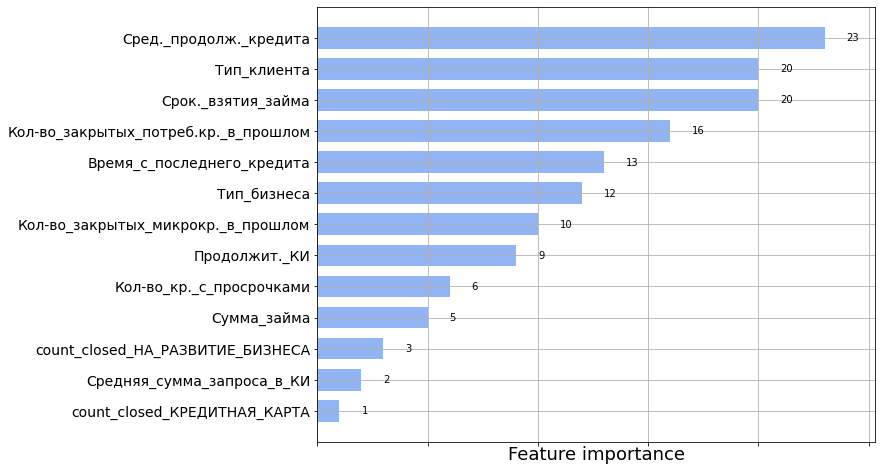

In [57]:
fig, ax = plt.subplots(figsize=(10, 8))

lgb.plot_importance(model.models[0], ax=ax, height=0.7, ylabel="", **{"color": "cornflowerblue", "alpha": 0.7})

ax.set_xlabel('Feature importance', fontsize=18)
plt.tick_params(labelsize=14, labelbottom=False)

plt.title("")
plt.savefig("Feature importance.jpg", bbox_inches = 'tight')
plt.show()

In [79]:
sns.set_style("whitegrid")

In [88]:
# ax.set_ylabel('')    
# ax.set_xlabel('Дата взятия займа', fontsize=18)

# covid_date = pd.Timestamp(year=2020, month=3, day=1)
# plt.axvline(x=covid_date, color="orange", label="Дата локдауна")
# plt.legend(fontsize=14)
# plt.tick_params(labelsize=14)

# plt.savefig("Плотность_дата_займа.jpg", bbox_inches = 'tight')

In [55]:
def rename_feature(df):
    df.rename(columns={"mean_rejected_amount": "Средняя сумма запроса в КИ", 
                       "mean_duration_loan": "Сред. продолж. кредита", 
                       "clientloantype": "Тип клиента",
                       "loan_terms_months": "Срок. взятия займа",
                       "count_closed_МИКРОКРЕДИТ": "Кол-во закрытых микрокр. в прошлом",
                       "duration_loan_history": "Продолжит. КИ",
                       "industry_codename_1": "Тип бизнеса",
                       "loan_principal": "Сумма займа",
                       "count_closed_ПОТРЕБИТ.КРЕДИТ": "Кол-во закрытых потреб.кр. в прошлом",
                       "count_loan_with_overdue": "Кол-во кр. с просрочками",
                       "diff_loan_issue_dt_last_loan": "Время с последнего кредита"
                       }, inplace=True)
    return df

In [71]:
rename_feature(prepared_data)

,application_id,Сумма займа,Срок. взятия займа,loan_issue_dt,Тип клиента,is_default,Тип бизнеса,Время с последнего кредита,Продолжит. КИ,Сред. продолж. кредита,...,Кол-во закрытых микрокр. в прошлом,Кол-во закрытых потреб.кр. в прошлом,count_closed_КРЕДИТНАЯ КАРТА,count_closed_АВТОКРЕДИТ,count_closed_НА УВЕЛИЧЕНИЕ ОБОРОТА,count_closed_НА РАЗВИТИЕ БИЗНЕСА,count_closed_ИПОТЕКА,count_closed_ОВЕРДРАФТ,count_closed_ЛИЗИНГ,Средняя сумма запроса в КИ
0,261,12.818281,7,2019-12-26,0,1,9,4.990433,-0.556827,6.394427,...,0,4,4,3,0,0,0,0,0,0.000000
1,1374,12.206073,6,2020-09-23,0,0,9,3.367296,-0.206329,8.140534,...,0,2,2,0,0,0,1,0,0,13.040849
2,167,13.997832,7,2019-12-26,2,1,7,5.899897,-0.983906,5.911700,...,4,0,0,2,0,0,0,0,0,14.588980
3,9210,14.038654,8,2020-10-20,1,0,10,3.637586,-1.184780,6.842565,...,0,1,3,1,1,0,0,0,0,13.925664
4,1061,13.592367,7,2020-09-03,0,0,9,3.465736,-1.710822,5.899897,...,0,0,0,0,0,0,0,0,0,13.199097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,4094,12.287653,8,2020-08-20,0,0,2,5.602119,-1.736152,0.000000,...,0,0,0,0,0,0,0,0,0,13.140531
277,1237,13.815511,4,2020-09-23,0,0,0,3.912023,-0.976837,8.095843,...,0,3,0,0,0,0,0,0,0,12.644328
278,8975,14.914123,5,2020-10-08,2,0,9,5.966147,1.111429,6.889155,...,1,14,2,1,1,7,0,0,0,13.017017
279,1365,14.185556,7,2020-02-21,1,1,9,3.663562,-1.613036,3.878121,...,41,0,1,0,0,0,0,0,0,12.464053


### Снижение размерности

In [40]:
data_for_pca = data.copy()

In [41]:
X = data_for_pca.iloc[:, (data_for_pca.columns != "application_id") & (data_for_pca.columns != "is_default") & (data_for_pca.columns != "loan_issue_dt")]
#X = X.values
y = data.is_default

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

In [43]:
pca.explained_variance_ratio_

array([0.14023097, 0.09998408])

In [44]:
df = pd.DataFrame({"app_id": data.application_id, '1': X_pca[:, 0], '2': X_pca[:, 1], 'y': data.is_default, \
                   "color": data.is_default, "loan_principal": data.loan_principal, "mean_rejected_amount": data.mean_rejected_amount})

In [45]:
df.color.replace(to_replace=1, value="Pink", inplace=True)
df.color.replace(to_replace=0, value="cornflowerblue", inplace=True)

In [72]:
df[(df['1'] < 10) & (df['1'] > 6)][["app_id", "loan_principal", "mean_rejected_amount"]]

,app_id,loan_principal,mean_rejected_amount
280,263,400000.0,751566.142857


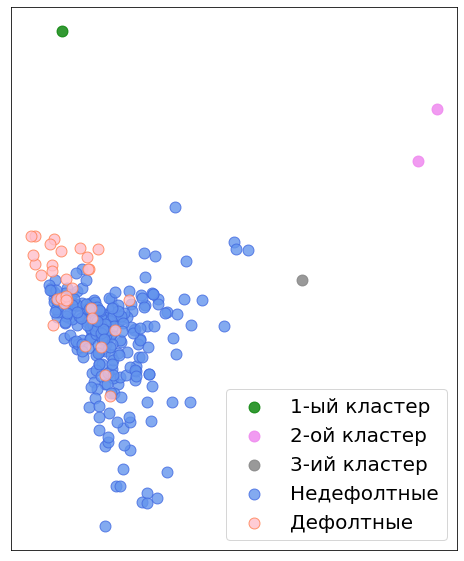

In [64]:
fig, ax = plt.subplots(figsize=(8, 10))


sns.regplot(data=df[df['2'] > 6], \
            x="1", y="2", fit_reg=False, scatter_kws={'color': "green", "edgecolors": "green", "s": 120}, ax=ax, label="1-ый кластер")
sns.regplot(data=df[(df['1'] > 10)], \
            x="1", y="2", fit_reg=False, scatter_kws={'color': "violet", "edgecolors": "violet", "s": 120}, ax=ax, label="2-ой кластер")

sns.regplot(data=df[(df['1'] < 10) & (df['1'] > 6)], \
            x="1", y="2", fit_reg=False, scatter_kws={'color': "gray", "edgecolors": "gray", "s": 120}, ax=ax, label="3-ий кластер")


sns.regplot(data=df[(df.y == 0) & (df['2'] < 6) & (df['1'] < 6)], \
            x="1", y="2", fit_reg=False, scatter_kws={'color': "cornflowerblue", "edgecolors": "royalblue", "s": 120}, ax=ax, label="Недефолтные")
sns.regplot(data=df[(df.y == 1) & (df['2'] < 6) & (df['1'] < 6)], \
            x="1", y="2", fit_reg=False, scatter_kws={'color': "pink", "edgecolors": "coral", "s": 120}, ax=ax, label="Дефолтные")

ax.set_yticklabels([])
ax.set_xticklabels([])
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
ax.legend(prop=font)
plt.savefig("pca.jpg", bbox_inches = 'tight')

plt.show()

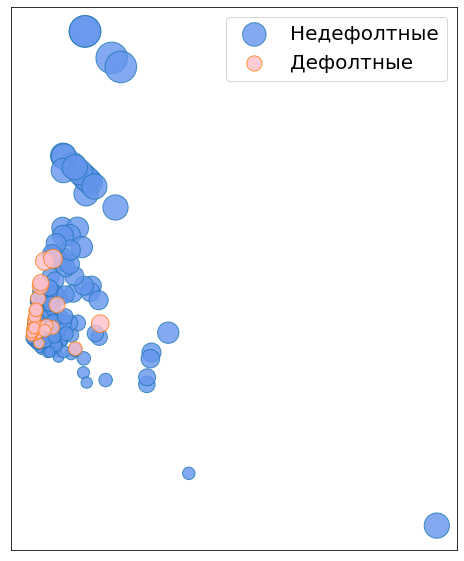

In [102]:
fig, ax = plt.subplots(figsize=(8, 10))

sns.regplot(data=df[df.color == "cornflowerblue"], \
            x="1", y="2", fit_reg=False, scatter_kws={'facecolors': df[df.y == 0]["color"], \
                                                      "s": df[df.y == 0]["loan_principal_size"]}, ax=ax, label="Недефолтные")
sns.regplot(data=df[df.color == "Pink"], \
            x="1", y="2", fit_reg=False, scatter_kws={'facecolors': df[df.y == 1]["color"], \
                                                      "s": df[df.y == 1]["loan_principal_size"]}, ax=ax, label="Дефолтные")

ax.set_yticklabels([])
ax.set_xticklabels([])
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
ax.legend(prop=font)
plt.savefig("pca_loan_amount.jpg", bbox_inches = 'tight')

plt.show()

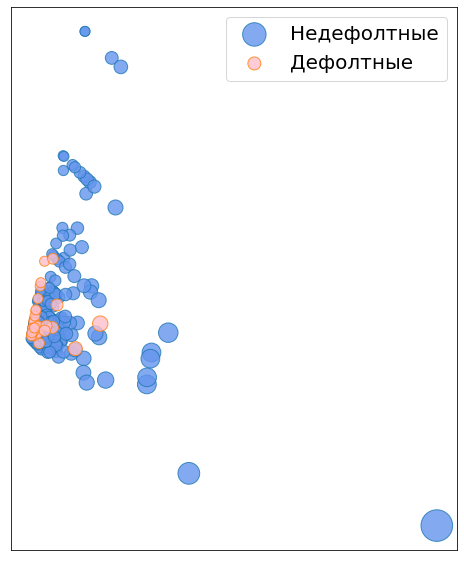

In [104]:
fig, ax = plt.subplots(figsize=(8, 10))

sns.regplot(data=df[df.color == "cornflowerblue"], \
            x="1", y="2", fit_reg=False, scatter_kws={'facecolors': df[df.y == 0]["color"], \
                                                      "s": df[df.y == 0]["mean_rejected_amount_size"]}, ax=ax, label="Недефолтные")
sns.regplot(data=df[df.color == "Pink"], \
            x="1", y="2", fit_reg=False, scatter_kws={'facecolors': df[df.y == 1]["color"], \
                                                      "s": df[df.y == 1]["mean_rejected_amount_size"]}, ax=ax, label="Дефолтные")

ax.set_yticklabels([])
ax.set_xticklabels([])
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
ax.legend(prop=font)
plt.savefig("pca_mean_reject.jpg", bbox_inches = 'tight')

plt.show()

In [70]:
df[df['2'] > 4e+6].app_id

105    50220
206    77370
Name: app_id, dtype: int64

In [73]:
data[data.application_id.isin(df[(df['2'] > 1.5e+6) & (df['2'] < 3e+6)].app_id)]

,application_id,loan_principal,loan_terms_months,loan_issue_dt,clientloantype,is_default,industry_codename_1,diff_loan_issue_dt_last_loan,duration_loan_history,mean_duration_loan,...,count_closed_МИКРОКРЕДИТ,count_closed_ПОТРЕБИТ.КРЕДИТ,count_closed_КРЕДИТНАЯ КАРТА,count_closed_АВТОКРЕДИТ,count_closed_НА УВЕЛИЧЕНИЕ ОБОРОТА,count_closed_НА РАЗВИТИЕ БИЗНЕСА,count_closed_ИПОТЕКА,count_closed_ОВЕРДРАФТ,count_closed_ЛИЗИНГ,mean_rejected_amount
42,147376,3000000.0,3,2020-12-01,0,0,10,2324,2324,1096.000000,...,0,0,0,1,0,0,0,0,0,2.000000e+06
59,106043,3000000.0,3,2020-11-26,0,0,10,1692,5471,1510.500000,...,0,6,2,2,0,0,0,0,0,1.000000e+00
77,2196,3000000.0,3,2020-10-08,0,0,0,492,3434,730.000000,...,9,6,3,0,0,0,0,0,0,1.022777e+06
131,9132,2790000.0,6,2020-10-14,0,0,10,307,2843,1163.545455,...,0,8,4,0,0,1,0,0,0,9.663073e+05
139,2333,3000000.0,6,2020-09-23,0,0,10,277,4513,797.250000,...,0,4,2,1,2,0,0,0,0,3.620000e+05
147,365,3000000.0,12,2020-08-25,0,0,10,594,2469,975.800000,...,0,3,0,1,0,0,0,0,0,8.000000e+05
166,80947,3000000.0,2,2020-11-10,0,0,0,524,4920,168.000000,...,0,2,0,0,0,0,0,0,0,3.000000e+04
190,1429,2800000.0,11,2020-09-29,2,0,18,91,1161,115.642857,...,26,0,0,0,0,0,0,0,0,9.373256e+04
211,33717,3000000.0,12,2020-11-05,0,0,10,126,2209,1711.222222,...,0,2,2,0,0,0,0,0,0,9.147015e+05
230,2038,3000000.0,3,2020-10-05,0,0,0,435,3739,1062.800000,...,0,8,0,0,0,0,0,0,0,6.460000e+05


In [75]:
data[data.application_id.isin(df[(df['1'] > 0.4e+7)].app_id)]

,application_id,loan_principal,loan_terms_months,loan_issue_dt,clientloantype,is_default,industry_codename_1,diff_loan_issue_dt_last_loan,duration_loan_history,mean_duration_loan,...,count_closed_МИКРОКРЕДИТ,count_closed_ПОТРЕБИТ.КРЕДИТ,count_closed_КРЕДИТНАЯ КАРТА,count_closed_АВТОКРЕДИТ,count_closed_НА УВЕЛИЧЕНИЕ ОБОРОТА,count_closed_НА РАЗВИТИЕ БИЗНЕСА,count_closed_ИПОТЕКА,count_closed_ОВЕРДРАФТ,count_closed_ЛИЗИНГ,mean_rejected_amount
63,9036,2000000.0,8,2020-10-13,2,0,6,134,3035,766.888889,...,2,2,0,0,3,0,0,0,0,4433842.5
204,27516,3000000.0,4,2020-10-22,0,0,15,1,1760,1.000000,...,0,0,0,0,0,0,0,0,0,14275000.0
258,46911,350000.0,6,2020-10-30,0,0,14,36,5109,2113.142857,...,0,2,2,1,0,0,1,0,0,5907410.0


In [57]:
df

,app_id,1,2,y,color,loan_principal,mean_rejected_amount
0,261,-6.664315e+05,-8.817746e+04,1,Pink,368900.0,1.000000e+00
1,1374,-3.061344e+05,-4.214999e+05,0,cornflowerblue,200000.0,4.608595e+05
2,167,1.653749e+06,-1.556152e+05,1,Pink,1200000.0,2.167271e+06
3,9210,7.031924e+05,2.951279e+05,0,cornflowerblue,1250000.0,1.116449e+06
4,1061,-2.191534e+03,1.018183e+05,0,cornflowerblue,800000.0,5.398771e+05
...,...,...,...,...,...,...,...
276,4094,-2.550067e+05,-4.244104e+05,0,cornflowerblue,217000.0,5.091667e+05
277,1237,-1.373397e+05,3.749089e+05,0,cornflowerblue,1000000.0,3.100000e+05
278,8975,7.619324e+05,2.166810e+06,0,cornflowerblue,3000000.0,4.500065e+05
279,1365,-1.211885e+04,8.078745e+05,1,Pink,1447800.0,2.588626e+05


In [68]:
import matplotlib.ticker as ticker

In [88]:
sns.set_style("whitegrid")

In [99]:
pd.set_option('float_format', '{:.1f}'.format)

In [105]:
df[(df['1'] < 0.42e7) & (df['1'] > 0.3e7)][["app_id", "loan_principal", "mean_rejected_amount"]]

,app_id,loan_principal,mean_rejected_amount
63,9036,2000000.0,4433842.5
94,2307,1000000.0,4032408.2
187,255,1500000.0,4000000.0
229,1299,1400000.0,4000000.0
242,1299,1100000.0,4000000.0


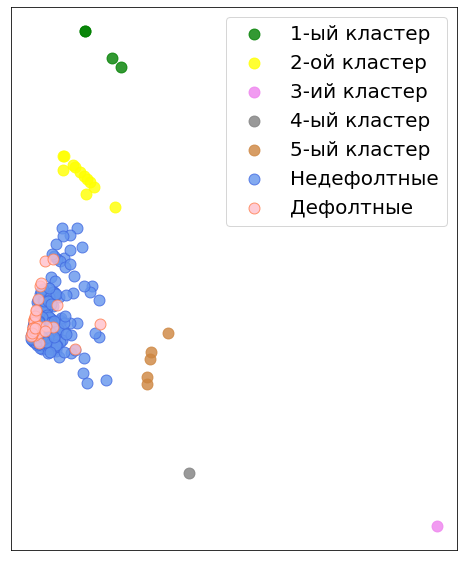

In [89]:
fig, ax = plt.subplots(figsize=(8, 10))

sns.regplot(data=df[df['2'] > 3e6], \
            x="1", y="2", fit_reg=False, scatter_kws={'color': "green", "edgecolors": "green", "s": 120}, ax=ax, label="1-ый кластер")
sns.regplot(data=df[(df['2'] < 3e6) & (df['2'] > 1.5e6)], \
            x="1", y="2", fit_reg=False, scatter_kws={'color': "yellow", "edgecolors": "yellow", "s": 120}, ax=ax, label="2-ой кластер")

sns.regplot(data=df[(df['1'] > 1e7)], \
            x="1", y="2", fit_reg=False, scatter_kws={'color': "violet", "edgecolors": "violet", "s": 120}, ax=ax, label="3-ий кластер")

sns.regplot(data=df[(df['1'] < 1e7) & (df['1'] > 0.42e7)], \
            x="1", y="2", fit_reg=False, scatter_kws={'color': "gray", "edgecolors": "gray", "s": 120}, ax=ax, label="4-ый кластер")

sns.regplot(data=df[(df['1'] < 0.42e7) & (df['1'] > 0.3e7)], \
            x="1", y="2", fit_reg=False, scatter_kws={'color': "peru", "edgecolors": "peru", "s": 120}, ax=ax, label="5-ый кластер")

sns.regplot(data=df[(df.y == 0) & (df['2'] < 1.5e6) & (df['1'] < 0.3e7)], \
            x="1", y="2", fit_reg=False, scatter_kws={'color': "cornflowerblue", "edgecolors": "royalblue", "s": 120}, ax=ax, label="Недефолтные")
sns.regplot(data=df[(df.y == 1) & (df['2'] < 1.5e6) & (df['1'] < 0.3e7)], \
            x="1", y="2", fit_reg=False, scatter_kws={'color': "pink", "edgecolors": "coral", "s": 120}, ax=ax, label="Дефолтные")

ax.set_yticklabels([])
ax.set_xticklabels([])
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
ax.legend(prop=font)
plt.savefig("pca.jpg", bbox_inches = 'tight')

plt.show()